In [100]:
import numpy as np
import matplotlib.pyplot as plt

In [101]:
def two_fish_schooling(alpha,beta,dt,T,theta_0):
    nSteps = np.ceil(T/dt).astype(int)
    t = np.arange(0,nSteps+1)*dt
    theta = np.zeros((len(t),2))
    theta[0,:] = theta_0
    for i in range(1,nSteps+1):
        theta[i,0] = theta[i-1,0] + dt*alpha*(theta[i-1,1]-theta[i-1,0])
        theta[i,1] = theta[i-1,1] + dt*beta*(theta[i-1,0]-theta[i-1,1])
    return t,theta
 

In this toy model of two fish copying each other deterministically, the differences in heading angles exponentially decay to zero

Text(0.5, 1.0, 'Two fish schooling')

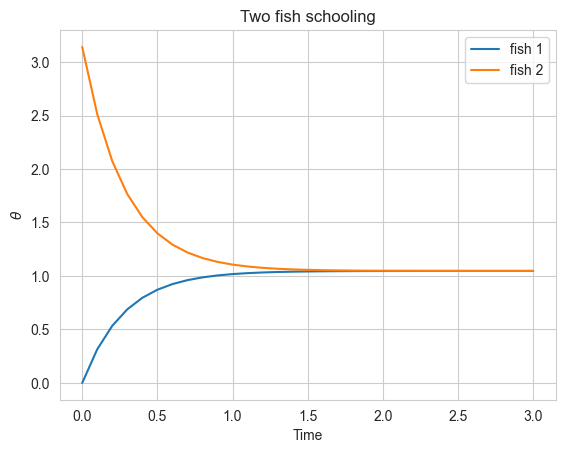

In [102]:
START_T = 0.0
END_T = 3.0
TOT_T = END_T - START_T
t, theta = two_fish_schooling(1,2,0.1,TOT_T,[0,np.pi])

# fig,ax = plt.subplots()
# ax.plot(t,theta[:,0],label="fish 1")
# ax.plot(t,theta[:,1],label="fish 2")
# ax.legend()
# ax.set_xlabel('Time')
# ax.set_ylabel(r"$\theta$")
# ax.set_title("Two fish schooling")

# Put the above in a function for later.
def plot_two_fish_schooling(t, theta):
    fig,ax = plt.subplots()
    ax.plot(t,theta[:,0],label="fish 1")
    ax.plot(t,theta[:,1],label="fish 2")
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel(r"$\theta$")
    return fig, ax
    
fig, ax = plot_two_fish_schooling(t, theta)
ax.set_title("Two fish schooling")

In [103]:
def polarization(theta):
    return np.sqrt((1+np.cos(theta[:,0]-theta[:,1]))/2)

 Polarization (|m|) exponentially approaches 1. Importantly, the dynamics of |m| only depend on the sum of copying rates ($\alpha$ + $\beta$), so individual differences cannot be inferred from polarization data

Text(0.5, 1.0, 'Two fish schooling')

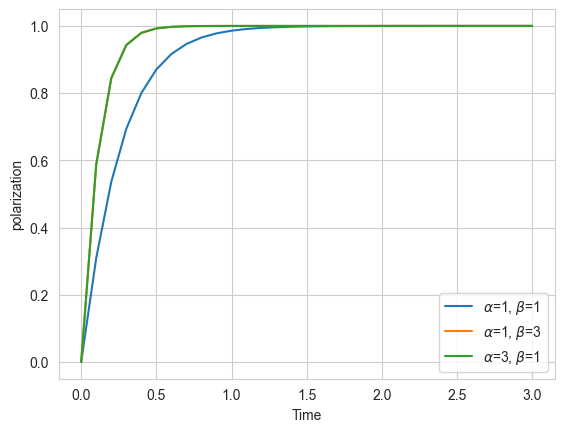

In [104]:
alpha = [1,1,3]
beta = [1,3,1]
t, theta_a = two_fish_schooling(alpha[0],beta[0],0.1,TOT_T,[0,np.pi])
t, theta_b = two_fish_schooling(alpha[1],beta[1],0.1,TOT_T,[0,np.pi])
t, theta_c = two_fish_schooling(alpha[2],beta[2],0.1,TOT_T,[0,np.pi])

m1 = polarization(theta_a)
m2 = polarization(theta_b)
m3 = polarization(theta_c)

def plot_polarizations(*ms_alphas_betas, t):
    fig,ax = plt.subplots()
    for (m, alpha, beta) in ms_alphas_betas:
        ax.plot(t,m,label=rf"$\alpha$={alpha}, $\beta$={beta}")
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel("polarization")
    return fig, ax

plot_polarizations(*tuple(zip((m1, m2, m3), alpha, beta)), t=t)
ax.set_title("Two fish schooling")

In [105]:
def two_fish_schooling_with_virtual(alpha,beta,dt,T,theta_0,A,omega):
    
    nSteps = np.ceil(T/dt).astype(int)
    t = np.arange(0,nSteps+1)*dt
    theta = np.zeros((len(t),2))
    theta[0,:] = theta_0
    #heading angle for virtual fish 
    theta_v = A*np.cos(omega*t)
    for i in range(1,nSteps+1):
        theta[i,0] = theta[i-1,0] + dt*alpha*(theta_v[i-1]+theta[i-1,1]-2*theta[i-1,0])
        theta[i,1] = theta[i-1,1] + dt*beta*(theta_v[i-1]+theta[i-1,0]-2*theta[i-1,1])
    return t,theta
 

Adding a virtual fish to the tank, which moves with a prescribed trajectory, causes the heading angles of the two fish to be entrained to the virtual fish with a lag

Text(0.5, 1.0, 'Two fish schooling with virtual fish')

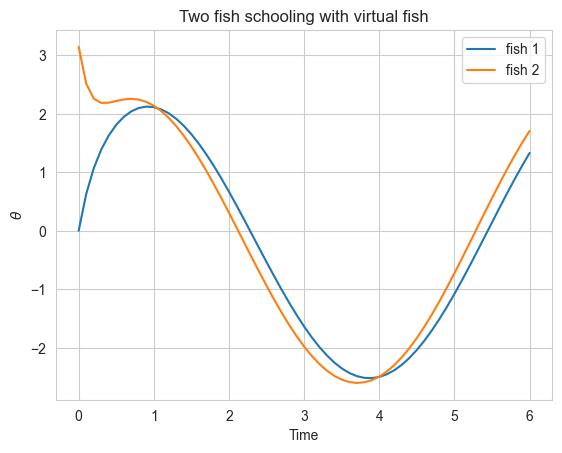

In [106]:
t, theta = two_fish_schooling_with_virtual(1,2,0.1,END_T*2.,[0,np.pi],A=np.pi,omega=1)

fig, ax = plot_two_fish_schooling(t, theta)
ax.set_title("Two fish schooling with virtual fish")

The dynamics of polarization ($|m|$) now depend on the individual copying rates ($\alpha$, $\beta$) in a subtle way 

Text(0.5, 1.0, 'Two fish schooling with virtual fish')

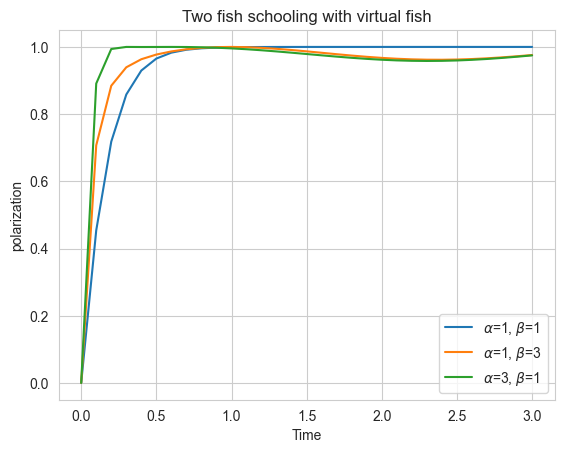

In [107]:
alpha = [1,1,3]
beta = [1,3,1]
A = np.pi
omega = 1
t, theta_a = two_fish_schooling_with_virtual(alpha[0],beta[0],0.1,TOT_T,[0,np.pi],A,omega)
t, theta_b = two_fish_schooling_with_virtual(alpha[1],beta[1],0.1,TOT_T,[0,np.pi],A,omega)
t, theta_c = two_fish_schooling_with_virtual(alpha[2],beta[2],0.1,TOT_T,[0,np.pi],A,omega)

m1 = polarization(theta_a)
m2 = polarization(theta_b)
m3 = polarization(theta_c)

fig,ax = plt.subplots()
ax.plot(t,m1,label=rf"$\alpha$={alpha[0]}, $\beta$={beta[0]}")
ax.plot(t,m2,label=rf"$\alpha$={alpha[1]}, $\beta$={beta[1]}")
ax.plot(t,m3,label=rf"$\alpha$={alpha[2]}, $\beta$={beta[2]}")
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel("polarization")
ax.set_title("Two fish schooling with virtual fish")

### Continuous Time Differential Equations
Now, we'll replicate the above but with support from `chirho`'s continuous time differential equations module, and generalize for arbitrary school sizes. 

In [108]:
from chirho_diffeqpy import DiffEqPy, ATempParams
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import simulate
from chirho.dynamical.handlers.trajectory import LogTrajectory
from chirho.dynamical.handlers import StaticBatchObservation, StaticIntervention, DynamicIntervention
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.observational.handlers import condition
from chirho.dynamical.ops import State
import numpy as np
import torch
from pyro import sample, set_rng_seed
from pyro.distributions import Uniform, Poisson
from typing import Tuple, Optional, Union, Callable
from functools import partial
from numbers import Real
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta, AutoMultivariateNormal
from contextlib import nullcontext
# DiffEqPy requires float64 values, so set the torch default dtype accordingly.
torch.set_default_dtype(torch.float64)
# The DiffEqPy backend interfaces with julia, so we must load a julia<>python interop backend.
import chirho_diffeqpy.lang_interop.julianumpy
# Global params are weird.
pyro.settings.set(module_local_params=True)

In [109]:
def build_fish_schooling_dynamics(virtual_fish_trajectory: Optional[Callable[[Real, ATempParams[np.ndarray]], Real]] = None):
    def fish_schooling_dynamics(state: State[np.ndarray], atemp_params: ATempParams[np.ndarray]):
        copy_coefs = atemp_params['copy_coefs']
        thetas = state['thetas']
        # print("-------------------------------------------------")
        # print("thetas", thetas.shape)
        # print("copy_coefs", copy_coefs.shape)
        
        # TODO use wraparound-aware difference?
        thetas_diff_mat = thetas[..., :, None] - thetas[..., None, :]
        
        # print("thetas_diff_mat", thetas_diff_mat.shape)
        
        if virtual_fish_trajectory is not None:
            virtual_fish_diff = virtual_fish_trajectory(state['t'], atemp_params) - thetas
            # print("virtual_fish_diff", virtual_fish_diff.shape)
        else:
            virtual_fish_diff = 0.0
        
        # TODO should this be a mean? Or just total?
        thetas_diff_tots = thetas_diff_mat.sum(axis=-2) + virtual_fish_diff
        # print("thetas_diff_tots", thetas_diff_tots.shape)
        assert thetas.shape == thetas_diff_tots.shape
    
        dthetas = thetas_diff_tots * copy_coefs
        
        # print("-------------------------------------------------")
        
        return {'thetas': dthetas}
    
    return fish_schooling_dynamics

#### Replicating the Two-Fish Setting

In [110]:
solver = DiffEqPy(abstol=1e-7, reltol=1e-7)

In [111]:
initial_state = dict(thetas=torch.tensor([0., torch.pi]))
true_params = dict(copy_coefs=torch.tensor([1., 2.]))
logging_times = torch.linspace(START_T, END_T, 100)

In [112]:
schooling_dynamics = build_fish_schooling_dynamics()

In [113]:
with LogTrajectory(times=logging_times) as logging_trajectory:
    with solver:
        simulate(schooling_dynamics, initial_state, torch.tensor(START_T), torch.tensor(END_T), atemp_params=true_params)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Time', ylabel='$\\theta$'>)

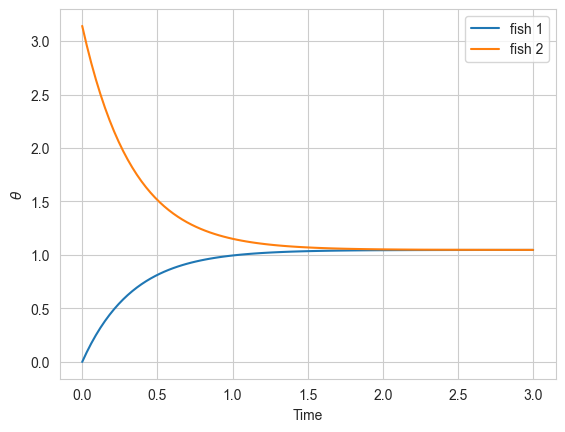

In [114]:
plot_two_fish_schooling(logging_trajectory.times, logging_trajectory.trajectory['thetas'].T)

In [115]:
def two_fish_torch_polarization(theta):
    return torch.sqrt((1+torch.cos(theta[...,0]-theta[...,1]))/2)

In [116]:
polarizations = []
for c1, c2 in zip(alpha, beta):
    true_params = dict(copy_coefs=torch.tensor([c1, c2]).double())
    with LogTrajectory(times=logging_times) as logging_trajectory:
        with solver:
            simulate(schooling_dynamics, initial_state, torch.tensor(START_T), torch.tensor(END_T), atemp_params=true_params)
    polarizations.append(
        two_fish_torch_polarization(logging_trajectory.trajectory['thetas'].T)
    )

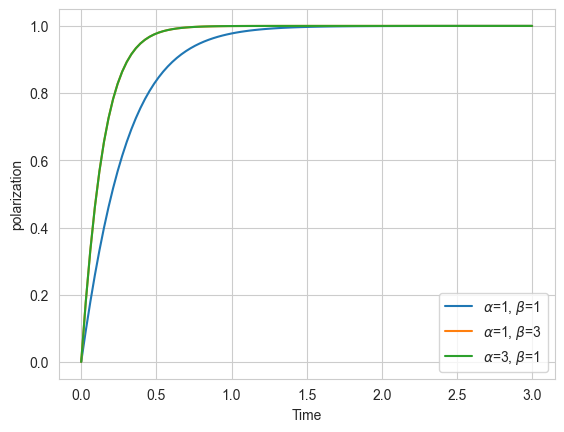

In [117]:
fig, ax = plot_polarizations(*tuple(zip(polarizations, alpha, beta)), t=logging_times)

In [118]:
def virtual_fish_trajectory(t, atemp_params: ATempParams):
    A = atemp_params['vfish_A']
    omega = atemp_params['vfish_omega']
    return A * np.cos(omega * t)

In [119]:
schooling_dynamics_with_virtual = build_fish_schooling_dynamics(virtual_fish_trajectory)

In [120]:
polarizations_with_virtual = []
for c1, c2 in zip(alpha, beta):
    true_params = dict(copy_coefs=torch.tensor([c1, c2]).double(), vfish_A=torch.tensor(np.pi).double(), vfish_omega=torch.tensor(1).double())
    with LogTrajectory(times=logging_times) as logging_trajectory:
        with solver:
            simulate(schooling_dynamics_with_virtual, initial_state, torch.tensor(START_T), torch.tensor(END_T), atemp_params=true_params)
    polarizations_with_virtual.append(
        two_fish_torch_polarization(logging_trajectory.trajectory['thetas'].T)
    )

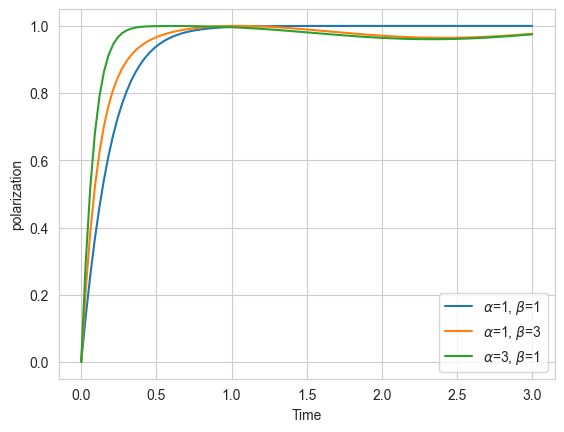

In [121]:
fig, ax = plot_polarizations(*tuple(zip(polarizations_with_virtual, alpha, beta)), t=logging_times)

### Capturing Non-Identification in Posterior

In [122]:
true_initial_state = dict(thetas=torch.tensor([0., torch.pi]))
def copy_coefs_prior():
    return pyro.sample('copy_coefs', Uniform(0.0, 10.).expand([len(true_initial_state["thetas"])]).to_event(1))

In [123]:
true_virtual_fish_params = dict(vfish_A=torch.tensor(np.pi), vfish_omega=torch.tensor(1.))
def sample_atemp_params():
    copy_coefs = copy_coefs_prior()
    return dict(copy_coefs=copy_coefs, **true_virtual_fish_params)

In [124]:
ARTIFICIAL_NOISE_PTR = [0.01]
def model_with_noisy_mesoscopic(virtual_fish_trajectory: Optional[Callable[[Real, ATempParams[np.ndarray]], Real]] = None):
    
    schooling_dynamics = build_fish_schooling_dynamics(virtual_fish_trajectory)
    
    atemp_params = sample_atemp_params()
    with LogTrajectory(times=logging_times) as logging_trajectory:
        with solver:
            simulate(schooling_dynamics, true_initial_state, torch.tensor(START_T), torch.tensor(END_T), atemp_params=atemp_params)
    thetas = logging_trajectory.trajectory['thetas']
    
    # print("thetas", thetas.shape)
    thetas_T = torch.transpose(thetas, -1, -2)
    # print("thetas_T", thetas_T.shape)
    m = two_fish_torch_polarization(thetas_T)
    
    # Add some superficial noise to m. TODO maybe expose the noise var globally so we can anneal it away as things converge?
    return pyro.sample("noisy_m", dist.Normal(m, ARTIFICIAL_NOISE_PTR[0]).to_event(1))

In [125]:
model = lambda: model_with_noisy_mesoscopic(virtual_fish_trajectory)
# model = lambda: model_with_noisy_mesoscopic()

In [126]:
# Plot prior predictive noisy polarizations.
with pyro.plate("prior_predictive", 10):
    noisy_m = model()

Text(0.5, 1.0, 'Prior Predictive Noisy Polarizations')

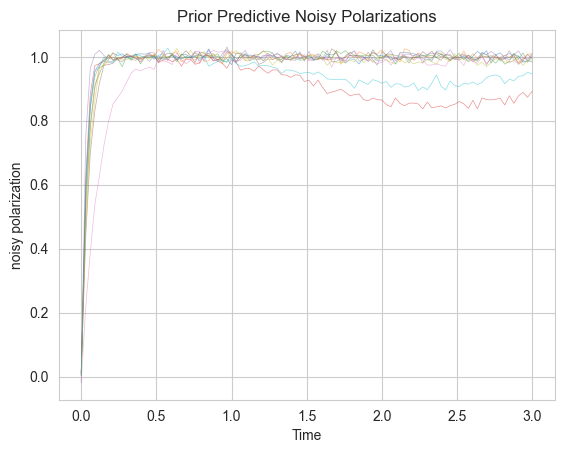

In [127]:
# Spaghetti plot the noisy_m as a visual sanity check.
def plot_noisy_polarizations(logging_times, noisy_m):
    fig, ax = plt.subplots()
    noisy_m_mT = noisy_m.mT if noisy_m.ndim > 2 else noisy_m.T
    ax.plot(logging_times, noisy_m_mT, linewidth=0.5, alpha=0.5)
    ax.set_xlabel('Time')
    ax.set_ylabel("noisy polarization")
    return fig, ax
_, ax = plot_noisy_polarizations(logging_times, noisy_m)
ax.set_title("Prior Predictive Noisy Polarizations")

In [128]:
true_copy_coefs = torch.tensor([1., 2.])
# Generate some synthetic data to fit, but condition on the true copy coefs as a cheater replay.
with pyro.condition(data={'copy_coefs': true_copy_coefs}):
    noisy_m_data = model()

Text(0.5, 1.0, 'Synthetic Data Noisy Polarizations')

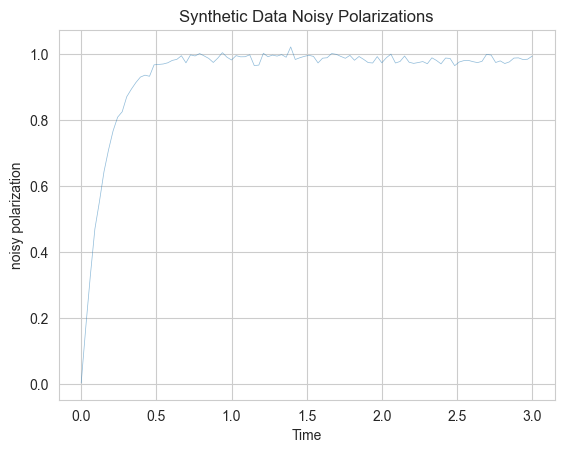

In [129]:
_, ax = plot_noisy_polarizations(logging_times, noisy_m_data)
ax.set_title("Synthetic Data Noisy Polarizations")

In [130]:
def build_svi(model, variational_family, *args, **kwargs):
    guide = variational_family(copy_coefs_prior, *args, **kwargs)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    elbo()  # initialize parameters.
    optim = torch.optim.Adam(elbo.parameters(), lr=1e-3)
    losses = []
    
    def svi_iter():
        optim.zero_grad()
        loss = elbo()
        loss.backward()
        optim.step()
        
        losses.append(loss.detach().item())
    
    return svi_iter, guide, losses

In [131]:
noisy_m_data.shape

torch.Size([100])

In [132]:
conditioned_model = pyro.condition(model, data={'noisy_m': noisy_m_data})

In [133]:
import pyro
import torch
import zuko
from pyro.contrib.zuko import ZukoToPyro
from pyro.contrib.easyguide import easy_guide

def build_zuko_guide(model, num_latents):
    flow = zuko.flows.NSF(features=num_latents, context=0, transforms=1, hidden_features=(16, 16))
    flow.transform = flow.transform.inv  # inverse autoregressive flow (IAF) are fast to sample from

    @easy_guide(model)
    def zuko_guide(self):
        # Match everything cz we're going to sample them as a joint normalizing flow.
        group = self.group(match=".*")

        return group.sample("joint_nf", ZukoToPyro(flow()))[-1]

    zuko_guide._parameters = dict(flow.named_parameters())

    return zuko_guide

In [134]:
# svi_iter, guide, losses = build_svi(conditioned_model, AutoMultivariateNormal)
svi_iter, guide, losses = build_svi(conditioned_model, build_zuko_guide, num_latents=2)

In [135]:
NUM_SVI_ITERS = 2000
for i in range(NUM_SVI_ITERS):
    print(f"\rProgress {i:03d}/{NUM_SVI_ITERS}", end="")
    svi_iter()

Progress 1999/2000

Text(0.5, 1.0, 'ELBO Loss over SVI Iterations')

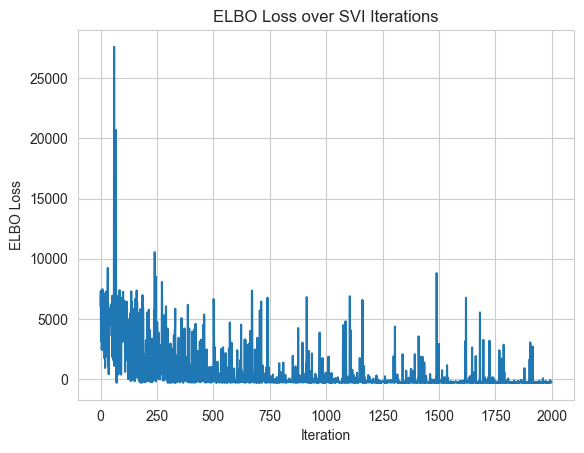

In [136]:
# Plot the losses.
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel('Iteration')
ax.set_ylabel('ELBO Loss')
ax.set_title('ELBO Loss over SVI Iterations')

In [137]:
with pyro.plate("posterior_samples", 10000):
    post_samples = guide()

(0.0, 4.0)

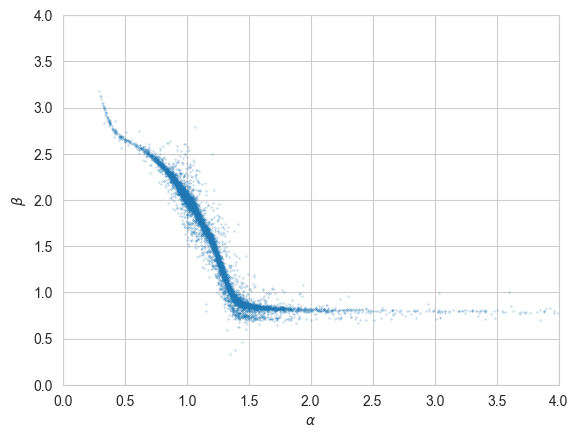

In [138]:
# Plot scatter of posterior samples.
fig, ax = plt.subplots()
ax.scatter(post_samples['copy_coefs'][:,0].detach(), post_samples['copy_coefs'][:,1].detach(), s=0.1, alpha=0.5)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\beta$")
# 0, 4 xlim ylim
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)

In [139]:
def estimate_entropy(guide, N):
    with pyro.poutine.trace() as tr:
        with pyro.plate("mc_for_entropy", N):
            guide()
    
    return -tr.get_trace().log_prob_sum() / N

In [140]:
estimate_entropy(guide, 1e4)

tensor(-1.4053, grad_fn=<DivBackward0>)